In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from stop_words import get_stop_words
from sklearn.decomposition import PCA
from sklearn.cluster import *
from sklearn.mixture import *
from umap import UMAP
from collections import Counter
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import TransformerMixin
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
from sklearn.base import clone as clone_estimator
import re

## Define some usefull functions

In [2]:
def aggregate_by_label(df: pd.DataFrame, label: str, min_threshold: int = 0):

    top_labels = df[label].value_counts()[df[label].value_counts() > min_threshold]
    
    entries = []
    for l in top_labels.index:
        label_df = df[df[label] == l]
        all_texts = []
        for text in label_df.text:
            all_texts.append(text)
        entry = {}
        
        conctanated_text = " ".join(all_texts)
        entry['label'] = l
        entry['text'] = conctanated_text
        entry['n_texts'] = len(all_texts)
        entry['n_tokens'] = len(conctanated_text.split())
        entry['instances'] = ", ".join(label_df.filename.to_list())
        
        entries.append(entry)
    return pd.DataFrame.from_records(entries)

In [3]:
def get_cluster_dfs(df, cluster):
    "Get one df with all entries from one cluster for all clusters"
    return [df[cluster == i] for i in np.unique(cluster)]

In [4]:
from plotly.colors import qualitative 

def plotly_color_categorical_values(values, cmap=qualitative.Light24):
    uniq = np.unique(values)
    if len(uniq) > len(cmap):
        print("Need more colors than current cmap holds")
        return
    categories_color = {cat: cmap[index] for index, cat in enumerate(uniq)}
    return [categories_color[cat] for cat in values]

In [5]:
from sklearn.model_selection import ParameterGrid
from sklearn.base import ClusterMixin
from tqdm import tqdm
from sklearn.base import clone as clone_estimator
from time import time

def _call_scoring(entry, score, data):
    try:
        entry[score.__name__] = score(data)
    except Exception as e:
        entry['Exception'] = e
    return entry

def tune(clu: ClusterMixin,
         X: np.ndarray,
         params: ParameterGrid,
         scoring: callable = None,
         verbose: bool = True):
    
    results = []
    params = tqdm(params) if verbose else params
    for param_comb in params:
        entry = {**param_comb}
        clu_instance = clone_estimator(clu)
        
        fit_start = time()
        clu_instance.fit(X)
        fit_time = time() - fit_start
        entry['fit_time'] = fit_time
        
        labels = clu_instance.predict(X)
        
        if scoring:
            if isinstance(scoring, list):
                for score in scoring:
                    _call_scoring(entry=entry, score=score, data=labels)
            if callable(scoring):
                _call_scoring(entry=entry, score=scoring, data=labels)
            else:
                raise Exception('Invalid scoring parameter passed')
        else:
            if hasattr(clu_instance, 'score') and callable(clu_instance.score):
                _call_scoring(entry=entry, score=clu_instance.score, data=X)
        results.append(entry)
        
    return pd.DataFrame.from_records(results)

In [6]:
class DenseTransformer(TransformerMixin):
    """
    Transformer for convert sparse data into dense.
    """
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.todense()

In [7]:
def merge_params_dicts(*args, sep='__'):
    """
    Merges n python dicts into one.
    If each dict is passed in a tuple where the first entry is a string,
    all keys in that dict will get the string as prefix
    """
    merged = {}
    for entry in args:
        if isinstance(entry, tuple):
            prefix = entry[0]
            merged.update({prefix + sep + key: value for key, value in entry[1].items()})
        if isinstance(entry, dict):
            merged.update(entry)
    return merged

In [8]:
def print_clusters(dfs):
    for index, cluster_df in enumerate(dfs):
        print(f'Cluster {index}')
        print(cluster_df.label)
        print(f'Total number of movies in cluster => {cluster_df.n_texts.sum()}')
        print(f'Total number of tokens in cluster => {cluster_df.n_tokens.sum()}')
        print('#'*60)

In [9]:
def cluster_distribution(cluster):
    cluster_counter = Counter(cluster)
    plt.bar(cluster_counter.keys(), cluster_counter.values())
    plt.show()
    return cluster_counter

## Load dataset

In [10]:
df = pd.read_csv('../dataset/movies_complete.csv')
df.dropna(subset=['genre'], inplace=True)
df['text_length'] = df.text.apply(lambda x: len(x.split()))
df = df[df['text_length'] >= 3000]

## Aggregate texts by Language attribute
We set the threshold to 1, every Language entry which occurs only one time is discarded

In [11]:
aggr = aggregate_by_label(df, 'Language', 3)

We compute the number of different languages (that occur alone at least one time in our aggregated dataset)
We will use this number as number of cluster later on.

In [12]:
single_labels = aggr.label[aggr.label.str.split(',').apply(lambda x: len(x)) == 1]
n_single_labels = len(single_labels)
single_labels, n_single_labels

(0          English
 1           French
 2           German
 3         Japanese
 5          Spanish
 6           Korean
 8          Turkish
 10        Mandarin
 14       Norwegian
 15           Dutch
 16          Danish
 17         Italian
 18         Swedish
 20         Russian
 21       Icelandic
 23       Cantonese
 25            Thai
 28           Hindi
 31      Portuguese
 38         Chinese
 47    Swiss German
 48           Greek
 53          Polish
 60          Arabic
 64        Romanian
 Name: label, dtype: object,
 25)

## Define feature extraction pipeline(s)

In [199]:
feature_pipe = make_pipeline(
    
    TfidfVectorizer(
        #stop_words=get_stop_words('de'),
        max_features=232,
        ngram_range=(1,1)),
    
    DenseTransformer(),
    
    UMAP(n_components=50,
         random_state=42),
)
feature_pipe

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(max_features=232)),
                ('densetransformer',
                 <__main__.DenseTransformer object at 0x7f8c6db0a970>),
                ('umap', UMAP(n_components=50, random_state=42))])

In [193]:
X = feature_pipe.fit_transform(aggr.text)

In [194]:
def filter_non_stopwords(s, stopwords=get_stop_words('de')):
    stopwords = set([t.lower() for t in stopwords])
    token = re.findall(r'\w+', s.lower())
    return " ".join([t for t in token if t in stopwords])

only_stopwords = aggr.text.apply(filter_non_stopwords)

In [195]:
len(get_stop_words('de'))

232

In [196]:
Xstop = feature_pipe.fit_transform(only_stopwords)

In [197]:
X = Xstop

## Compute 2D Umap-Representation of our data
We use the same pipeline for computing 2D data for plotting our results

In [198]:
Xr = UMAP(n_components=2, n_neighbors=3).fit_transform(X)
fig = go.Figure(data=go.Scatter(x=Xr[:, 0],
                                y=Xr[:, 1],
                                mode='markers',
                                text=[f'{label}|{n_token}' for label, n_token in zip(aggr.label, aggr.n_texts)],
                                marker_color=aggr.n_tokens))


fig.show()

# KMeans-Clustering

In [200]:
kmeans = KMeans(n_clusters=n_single_labels)
kmean_cluster = kmeans.fit_predict(X)
kmeans_dfs = get_cluster_dfs(aggr, kmean_cluster)

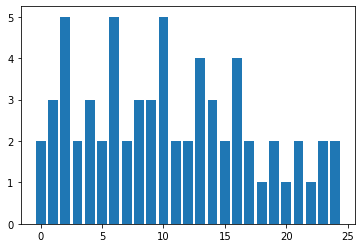

In [201]:
kmeans_cluster_counts = cluster_distribution(kmean_cluster)

In [202]:
kmeans_dfs[1].head()

,label,text,n_texts,n_tokens,instances
8,Turkish,Das Ei Hallo ... Hallo ... Yusuf ? Ich rufe au...,45,485290,"3283602.xml, 4499587.xml, 3358575.xml, 3368846..."
17,Italian,Am Anfang war das Wasser . Und Wasser ist Lebe...,18,143324,"4445071.xml, 4224160.xml, 6183526.xml, 5752163..."
21,Icelandic,"Ich sitze im Gefängnis , weil ich wegen Mordes...",15,98198,"4246157.xml, 4554648.xml, 3859797.xml, 6815756..."


In [203]:
print_clusters(kmeans_dfs)

Cluster 0
19    English, Japanese
53               Polish
Name: label, dtype: object
Total number of movies in cluster => 23
Total number of tokens in cluster => 156431
############################################################
Cluster 1
8       Turkish
17      Italian
21    Icelandic
Name: label, dtype: object
Total number of movies in cluster => 78
Total number of tokens in cluster => 726812
############################################################
Cluster 2
0                 English
4        English, Spanish
32    English, Portuguese
42       Swedish, English
46        English, Hebrew
Name: label, dtype: object
Total number of movies in cluster => 1479
Total number of tokens in cluster => 13185841
############################################################
Cluster 3
5                     Spanish
54    English, Arabic, Hebrew
Name: label, dtype: object
Total number of movies in cluster => 75
Total number of tokens in cluster => 554044
###########################################

In [140]:
kmeans_dbscore = davies_bouldin_score(X, kmean_cluster)
kmeans_dbscore

0.9325565231385573

In [141]:
kmeans_chscore = calinski_harabasz_score(X, kmean_cluster)
kmeans_chscore

5.874542408446575

# DBSCAN-Clustering

In order to find a suitable value for the min-distance parameter ```eps``` we compute the mean distance between all datatpoints

In [142]:
from scipy.spatial.distance import pdist, squareform, cosine
dm = squareform(pdist(X, cosine))

In [143]:
dm.mean()

0.021004571547312254

Now we choose a value near the mean distance as eps and set the min_samples param for density reachability to a low value since we do not have many points in our dataset.

In [182]:
dbscan = DBSCAN(metric='cosine', eps=0.009, min_samples=2)

In [183]:
dbscan_cluster = dbscan.fit_predict(X)

In [184]:
dbscan_dfs = get_cluster_dfs(aggr, dbscan_cluster)

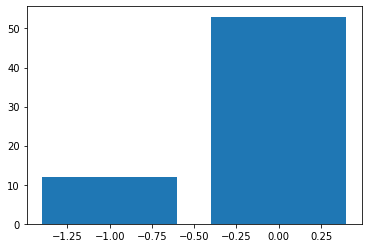

In [185]:
dbscan_cluster_counts = cluster_distribution(dbscan_cluster)

In [153]:
print(len(dbscan_cluster_counts))

5


=> The number data points marked as noise is surpringly low
=> The min_samples param has great influence on the number of clusters that the algorithm will find

In [154]:
noise = aggr[dbscan_cluster == -1]
noise

,label,text,n_texts,n_tokens,instances
6,Korean,Dein Vater war ein ausgezeichneter Kämpfer . A...,51,395234,"5594522.xml, 3691322.xml, 6968595.xml, 6271648..."
7,"English, French",Mitten in der Nacht habe ich einen Alptraum . ...,51,484261,"6483160.xml, 5589212.xml, 3335888.xml, 6984636..."
8,Turkish,Das Ei Hallo ... Hallo ... Yusuf ? Ich rufe au...,45,485290,"3283602.xml, 4499587.xml, 3358575.xml, 3368846..."
10,Mandarin,Nach dem Cartoon von Chang Leping Mit Jialin a...,33,237221,"6254411.xml, 5584814.xml, 5983854.xml, 4648055..."
14,Norwegian,"Ich weiß nicht , wann es begann , oder wie es ...",23,147740,"4903811.xml, 5862471.xml, 4918401.xml, 4413003..."
16,Danish,Ein Film von Ole Bornedal Liebesszene Nr. 1 Hi...,21,144459,"6001494.xml, 4732464.xml, 6692042.xml, 3636537..."
17,Italian,Am Anfang war das Wasser . Und Wasser ist Lebe...,18,143324,"4445071.xml, 4224160.xml, 6183526.xml, 5752163..."
18,Swedish,"PATRIK , AGE 1 / 5 Basierend auf einem Stück v...",18,136157,"3592485.xml, 4887280.xml, 5252151.xml, 3855929..."
21,Icelandic,"Ich sitze im Gefängnis , weil ich wegen Mordes...",15,98198,"4246157.xml, 4554648.xml, 3859797.xml, 6815756..."
24,"English, Italian",DER weiße HAI IN VENEDIG ( 2008 ) dTV - HR - 0...,13,147809,"4535688.xml, 5096547.xml, 4165838.xml, 4138330..."


In [155]:
fig = go.Figure(data=go.Scatter(x=Xr[:, 0],
                                y=Xr[:, 1],
                                mode='markers',
                                text=[
                                    f'{label}|{n_texts}|{n_tokens}' for label, n_texts, n_tokens in zip(aggr.label, aggr.n_texts, aggr.n_tokens)
                                ],
                                marker_color=plotly_color_categorical_values(dbscan_cluster)))


fig.show()

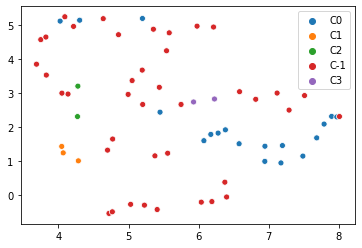

In [156]:
import seaborn as sns
sns.scatterplot(x=Xr[:, 0],
                y=Xr[:, 1],
               hue=[f'C{i}' for i in dbscan_cluster])

In [157]:
if len(dbscan_cluster_counts) > 1:
    dbscan_dbscore = davies_bouldin_score(X, dbscan_cluster)
else:
    dbscan_dbscore = None
dbscan_dbscore

2.7017051854822056

In [158]:
if len(dbscan_cluster_counts) > 1:
    dbscan_chscore = calinski_harabasz_score(X, dbscan_cluster)
else:
    dbscan_chscore = None
dbscan_chscore

2.015132364595488

## GaussianMixtureModels Clustering

In [159]:
gmm = GaussianMixture(n_components=n_single_labels)

In [160]:
gmm_cluster = gmm.fit_predict(X)
probs = gmm.predict_proba(X)

In [161]:
gmm_dfs = get_cluster_dfs(aggr, gmm_cluster)

gmm_cluster_counts = cluster_distribution(gmm_cluster)

In [162]:
fig = go.Figure(data=go.Scatter(x=Xr[:, 0],
                                y=Xr[:, 1],
                                mode='markers',
                                text=[f'{label}|{n_token}' for label, n_token in zip(aggr.label, aggr.n_texts)],
                                marker_color=plotly_color_categorical_values(gmm_cluster)))


fig.show()

Need more colors than current cmap holds


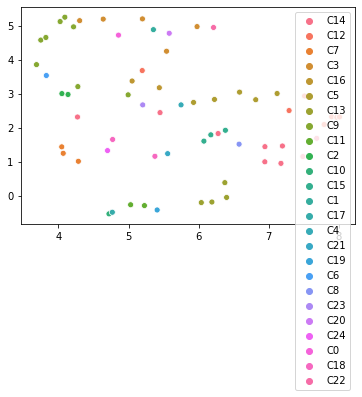

In [163]:
import seaborn as sns
sns.scatterplot(x=Xr[:, 0],
                y=Xr[:, 1],
               hue=[f'C{i}' for i in gmm_cluster])

In [164]:
print_clusters(gmm_dfs)

Cluster 0
57    Thai, English
Name: label, dtype: object
Total number of movies in cluster => 4
Total number of tokens in cluster => 22157
############################################################
Cluster 1
30    Spanish, English
Name: label, dtype: object
Total number of movies in cluster => 10
Total number of tokens in cluster => 69555
############################################################
Cluster 2
16               Danish
29    Japanese, English
Name: label, dtype: object
Total number of movies in cluster => 31
Total number of tokens in cluster => 201494
############################################################
Cluster 3
5              Spanish
23           Cantonese
40      French, Arabic
52    English, Chinese
60              Arabic
Name: label, dtype: object
Total number of movies in cluster => 99
Total number of tokens in cluster => 741385
############################################################
Cluster 4
43    English, French, German
Name: label, dtype: object
To

In [84]:
gmm_dbscore = davies_bouldin_score(X, gmm_cluster)
gmm_dbscore

0.7901722010593853

In [85]:
gmm_chscore = calinski_harabasz_score(X, gmm_cluster)
gmm_chscore

32.34682508162946

In [101]:
probs[(probs < 1.0) & (probs > 0.0)]

array([], dtype=float64)

In [188]:
print(get_stop_words('de'))

['aber', 'alle', 'allem', 'allen', 'aller', 'alles', 'als', 'also', 'am', 'an', 'ander', 'andere', 'anderem', 'anderen', 'anderer', 'anderes', 'anderm', 'andern', 'anders', 'auch', 'auf', 'aus', 'bei', 'bin', 'bis', 'bist', 'da', 'damit', 'dann', 'das', 'dass', 'dasselbe', 'dazu', 'daß', 'dein', 'deine', 'deinem', 'deinen', 'deiner', 'deines', 'dem', 'demselben', 'den', 'denn', 'denselben', 'der', 'derer', 'derselbe', 'derselben', 'des', 'desselben', 'dessen', 'dich', 'die', 'dies', 'diese', 'dieselbe', 'dieselben', 'diesem', 'diesen', 'dieser', 'dieses', 'dir', 'doch', 'dort', 'du', 'durch', 'ein', 'eine', 'einem', 'einen', 'einer', 'eines', 'einig', 'einige', 'einigem', 'einigen', 'einiger', 'einiges', 'einmal', 'er', 'es', 'etwas', 'euch', 'euer', 'eure', 'eurem', 'euren', 'eurer', 'eures', 'für', 'gegen', 'gewesen', 'hab', 'habe', 'haben', 'hat', 'hatte', 'hatten', 'hier', 'hin', 'hinter', 'ich', 'ihm', 'ihn', 'ihnen', 'ihr', 'ihre', 'ihrem', 'ihren', 'ihrer', 'ihres', 'im', 'in', 

In [190]:
tf = TfidfVectorizer(max_features=100).fit(aggr.text)

In [191]:
tf.vocabulary_

{'die': 23,
 'also': 4,
 'das': 16,
 'der': 21,
 'in': 48,
 'den': 19,
 'und': 84,
 'haben': 38,
 'vor': 87,
 'sie': 80,
 'dass': 17,
 'es': 31,
 'eine': 28,
 'so': 82,
 'nur': 72,
 'wenn': 91,
 'einen': 29,
 'wird': 97,
 'von': 86,
 'mit': 65,
 'dem': 18,
 'ist': 49,
 'ihn': 44,
 'kann': 52,
 'mir': 64,
 'zu': 99,
 'als': 3,
 'was': 89,
 'schon': 76,
 'aber': 0,
 'nicht': 69,
 'werden': 92,
 'keine': 53,
 'hat': 40,
 'ja': 50,
 'an': 5,
 'uns': 85,
 'auf': 7,
 'wo': 98,
 'denn': 20,
 'für': 33,
 'aus': 8,
 'wir': 96,
 'bei': 9,
 'er': 30,
 'sich': 79,
 'noch': 71,
 'oder': 73,
 'man': 58,
 'doch': 25,
 'sein': 78,
 'um': 83,
 'wie': 93,
 'da': 13,
 'alles': 2,
 'sehr': 77,
 'im': 46,
 'war': 88,
 'auch': 6,
 'ihr': 45,
 'ein': 27,
 'alle': 1,
 'mehr': 60,
 'nichts': 70,
 'machen': 56,
 'dann': 15,
 'nach': 67,
 'gut': 35,
 'wieder': 94,
 'immer': 47,
 'sind': 81,
 'mal': 57,
 'hier': 42,
 'ich': 43,
 'muss': 66,
 'hab': 36,
 'jetzt': 51,
 'habe': 37,
 'mich': 63,
 'du': 26,
 'mann': 5